# Vaccine sentiment classification using fine-tuned BERT-based Model
Pavlos Spanoudakis (sdi1800184)

Colab does not have `transformers` pre-installed.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp ./drive/MyDrive/NLP/vaccine_train_set.csv ./
!cp ./drive/MyDrive/NLP/vaccine_validation_set.csv ./

!pip install transformers

Mounted at /content/drive
     |████████████████████████████████| 3.8 MB 5.6 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 6.5 MB 20.8 MB/s 
     |████████████████████████████████| 596 kB 10.6 MB/s 
     |████████████████████████████████| 895 kB 33.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Select one of the models presented in the report:

In [2]:
MODEL_1 = 1
MODEL_2 = 2
MODEL_3 = 3

MODEL = MODEL_1

### Setting up Dataset paths & Class-Related information

In [3]:
TRAIN_SET_PATH = "./vaccine_train_set.csv"
VALIDATION_SET_PATH = "./vaccine_validation_set.csv"

NUM_CLASSES = 3
CLASS_NAMES = ['Neutral', 'Anti-Vaccine', 'Pro-Vaccine']

### Necessary Imports

In [4]:
# Built-in Python libraries
from typing import Callable, Iterable, List, Dict, Tuple
from numbers import Number
import re
import random
import os

# 3rd party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Transformers libraries
from transformers import BertTokenizer, BertModel

# scikit-learn metrics
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay, precision_recall_fscore_support

### Setting up hyperparameters & NN structure

In [5]:
BERT_CLS_SIZE = 768
if MODEL == MODEL_1:
    LEARNING_RATE = 0.00003
    BATCH_SIZE = 64
    EPOCHS = 2
    MAX_LENGTH = 100
    DROPOUT = 0.2
elif MODEL == MODEL_2:
    LEARNING_RATE = 0.000005
    BATCH_SIZE = 32
    EPOCHS = 3
    MAX_LENGTH = 100
    DROPOUT = 0.25
elif MODEL == MODEL_3:
    LEARNING_RATE = 0.00001
    BATCH_SIZE = 16
    EPOCHS = 2
    MAX_LENGTH = 100
    DROPOUT = 0.1

### Enabling GPU acceleration

In [6]:
CPU_DEVICE = 'cpu'
CUDA_DEVICE = 'cuda'
DEVICE = CUDA_DEVICE if torch.cuda.is_available() else CPU_DEVICE

### Setting custom seeds in pseudo-random generators for reproducability

In [7]:
# The GPU-accelerated results cannot be reproduced, but this is the preferred seed.
SEED = 256
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(SEED)

### Checking the CSV's for empty/null cells

In [8]:
trainDF = pd.read_csv(TRAIN_SET_PATH)
trainDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

In [9]:
validDF = pd.read_csv(VALIDATION_SET_PATH)
validDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

### Trimming the created data frames and extracting only the required data

In [10]:
features = trainDF.drop(['label', 'Unnamed: 0'], axis=1)
X_train = np.array([ar[0] for ar in features.values])
trainLabels = trainDF['label'].values

features = validDF.drop(['label', 'Unnamed: 0'], axis=1)
X_valid = np.array([ar[0] for ar in features.values])
validLabels = validDF['label'].values

### Creating a Dataset class

In [11]:
bertTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenizer(text: str):
    return bertTokenizer(text, padding='max_length', max_length=MAX_LENGTH, truncation=True, return_tensors="pt")

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, tweets, labels) -> None:
        super().__init__()

        self.labels = labels
        self.tweets = [tokenizer(tweet) for tweet in tweets]

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, index):
        return self.tweets[index], self.labels[index]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Creating the BERT Classifier

In [12]:
class BertTweetClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(p=DROPOUT)
        self.linear = nn.Linear(BERT_CLS_SIZE, NUM_CLASSES)
        self.relu = nn.ReLU()

    def forward(self, input, mask):
        _, bertOut = self.bert(input_ids=input, attention_mask=mask, return_dict=False)
        ffOut = self.linear(self.dropout(bertOut))

        return self.relu(ffOut)

### Training the Model

In [13]:
def trainModel(model, optimizer, trainSetLoader, validSetLoader):
    # Loss, F1 Score & Total Predictions after every epoch are stored here
    lastEpochValidOutput: List[Number] = []
    epochValidPredictions: List[int]
    epochTrainPredictions: List[int]

    # Epochs loop
    for epoch in range(EPOCHS):
        # Set model to train mode
        trainEpochLabels = []
        epochTrainPredictions = []
        trainBatchLosses = []
        trainBatchAccs = []

        validEpochLabels = []
        epochValidPredictions = []
        validBatchLosses = []
        validBatchAccs = []

        model.train()

        # Batch loop
        for tweets, labels in trainSetLoader:
            labels = labels.to(DEVICE)
            inputIds = tweets['input_ids'].squeeze(1).to(DEVICE)
            masks = tweets['attention_mask'].to(DEVICE)
            # Make predictions for batch samples
            predictions = model(inputIds, masks)

            # Extract & store predicted labels and calculate accuracy
            predictedLabels = getPredictedLabels(predictions)
            trainBatchAccs.append(calculateAccuracy(predictedLabels, labels))

            # Run loss function, store loss & backpropagate
            batchLoss = lossFunction(predictions, labels.long())
            trainBatchLosses.append(batchLoss.item())
            
            if epoch == EPOCHS - 1:
                epochTrainPredictions.extend(predictedLabels)
                trainEpochLabels.extend(labels.cpu())

            optimizer.zero_grad()

            batchLoss.backward()

            optimizer.step()

        # Set model to evaluation mode
        model.eval()
        with torch.no_grad():
            
            for tweets, labels in validSetLoader:
                labels = labels.to(DEVICE)
                inputIds = tweets['input_ids'].squeeze(1).to(DEVICE)
                masks = tweets['attention_mask'].to(DEVICE)
                # Make predictions for batch samples
                predictions = model(inputIds, masks)

                # Extract & store predicted labels and calculate accuracy
                predictedLabels = getPredictedLabels(predictions)                
                validBatchAccs.append(calculateAccuracy(predictedLabels, labels))

                # Run loss function & store loss
                batchLoss = lossFunction(predictions, labels.long())
                validBatchLosses.append(batchLoss.item())

                if epoch == EPOCHS - 1:
                    validEpochLabels.extend(labels.cpu())
                    epochValidPredictions.extend(predictedLabels)
                    lastEpochValidOutput.extend(predictions.cpu())

        # Find the total epoch loss for both sets
        trainError = sum(trainBatchLosses)/len(trainBatchLosses)        
        validError = sum(validBatchLosses)/len(validBatchLosses)
        
        print(f"############ Epoch {epoch} ############")
        print(f"TRAIN Acc: {sum(trainBatchAccs)/len(trainBatchAccs):.5f} Loss: {trainError:.5f}")
        print(f"VALID Acc: {sum(validBatchAccs)/len(validBatchAccs):.5f} Loss: {validError:.5f}")

    return (validEpochLabels, epochValidPredictions, lastEpochValidOutput,
            trainEpochLabels, epochTrainPredictions)

### Converting the NN output to predictions
We apply `log_softmax` to the output vector and map each vector to the index of the maximum element of the vector.

In [14]:
def getPredictedLabels(predictions: torch.Tensor) -> np.ndarray:
    softmaxLayerOut = torch.log_softmax(predictions, dim = 1)
    _, labels = torch.max(softmaxLayerOut, dim = 1)
    return labels.cpu().detach().numpy()

### Calculating macro accuracy

In [15]:
def calculateAccuracy(predictedLabels: Iterable[Number], trueLabels: Iterable[Number]) -> float:    
    correct = 0
    for pred, true in zip(predictedLabels, trueLabels):
        correct += int(pred == true)
    
    return correct/len(trueLabels)*100

### Plotting a confusion matrix
We can change the displayed labels (`0` -> `Neutral`, `1` -> `Anti-Vaccine`, `2` -> `Pro-Vaccine`) if desired.

In [16]:
def plotConfusionMatrix(trueLabels: Iterable[int], predictions:Iterable[int], title: str, displayLabels: Iterable[str]=None, axes: plt.Axes=None):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(6,5))
    disp = ConfusionMatrixDisplay.from_predictions(trueLabels, predictions, cmap=plt.cm.Reds, ax=axes, colorbar=False)
    if displayLabels is not None:
        disp.ax_.set_xticklabels(displayLabels)
        disp.ax_.set_yticklabels(displayLabels)
    axes.set_xlabel('Classifier predicted labels', fontsize=11)
    axes.set_ylabel('True labels', fontsize=11)
    axes.set_title(title, fontsize=14)

### Calculating metric scores on the trained model predictions
- For each different training set size, we calculate the **F1**, **Precision** and **Recall** scores
of the predictions made by the classifier after the end of the train phase, on the training & validation sets.
- We store these scores in two `dict` objects which we return.

In [17]:
F1_KEY = "F1"
PREC_KEY = "Precision"
REC_KEY = "Recall"

def metricScores(trainPredictions: Iterable[int], validPredictions: Iterable[int], trainLabels: Iterable[int], validLabels: Iterable[int]):

    tScoresArray = precision_recall_fscore_support(trainPredictions, trainLabels, labels=[i for i in range(NUM_CLASSES)], average=None)
    vScoresArray = precision_recall_fscore_support(validPredictions, validItrlabels, labels=[i for i in range(NUM_CLASSES)], average=None)

    tScores = {}
    vScores = {}
    for scoresDict, scoresArray in ((tScores, tScoresArray), (vScores, vScoresArray)):
        for cls, classScores in zip(CLASS_NAMES, scoresArray):
            scoresDict[cls] = {
                PREC_KEY: round(classScores[0], 4),
                REC_KEY: round(classScores[1], 4),
                F1_KEY: round(classScores[2], 4)
            }
    
    return tScores, vScores

### Getting the final scores in a data frame
We place the scores of the predictions made after the end of training in a data frame for better readability.

In [18]:
def metricStatsDF(scores: Tuple[Dict[str, Dict[str, Number]]], metrics):
    def datasetMetricDF(scores: Dict[str, Dict[str, Number]], metrics):
        metricStats: Dict[str, List[Number]] = {}
        for metric in metrics:
            metricStats[metric] = [scores[cls][metric] for cls in scores]
        
        df = pd.DataFrame(metricStats, index=CLASS_NAMES)
        df.style.set_caption("Hello World")
        return df

    tdf = datasetMetricDF(scores[0], metrics)
    vdf = datasetMetricDF(scores[1], metrics)
    return pd.concat([tdf, vdf], keys=['Train Set', 'Validation Set'], axis=1)

### Creating & Plotting ROC Curves for the Validation Set predictions
We mirror the usage of `roc_curve` from scikit-learn for multiple classes, as demonstrated [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multiclass-problem).

In [19]:
def createRocCurves(trueLabels: Iterable[int] , predictions: torch.Tensor):
    labels = np.zeros((len(trueLabels), NUM_CLASSES), dtype=int)
    for index, label in enumerate(trueLabels):
        labels[index][label] = 1
    scores = torch.softmax(predictions, dim = 1).detach().numpy()

    fpr: Dict[int, np.ndarray] = {}
    tpr: Dict[int, np.ndarray] = {}
    roc_auc: Dict[int, np.ndarray] = {}
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], scores[:, i], drop_intermediate=True)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    return fpr, tpr, roc_auc

def plotRocCurves(fpRates: Dict[int, np.ndarray], tpRates: Dict[int, np.ndarray], aucScores: Dict[int, np.ndarray]):
    plt.figure(figsize=(7,7))
    plt.grid()

    for i in range(NUM_CLASSES):
        plt.plot(
            fpRates[i],
            tpRates[i],
            label=f"{CLASS_NAMES[i]} (area = {aucScores[i]:0.2f})"
        )

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.show()
    pass

## Execution Flow

In [20]:
trainDataset = TweetDataset(X_train, trainLabels)
trainSetLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=False)

validDataset = TweetDataset(X_valid, validLabels)
validSetLoader = DataLoader(validDataset, batch_size=BATCH_SIZE, shuffle=False)

model = BertTweetClassifier().to(DEVICE)
lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
(validItrlabels,
 validPredictions,
 validOutput,
 trainLabels,
 epochTrainPredictions) = trainModel(model, optimizer, trainSetLoader, validSetLoader)

############ Epoch 0 ############
TRAIN Acc: 69.52750 Loss: 0.71223
VALID Acc: 76.47156 Loss: 0.57269
############ Epoch 1 ############
TRAIN Acc: 80.43375 Loss: 0.50047
VALID Acc: 77.23008 Loss: 0.57576


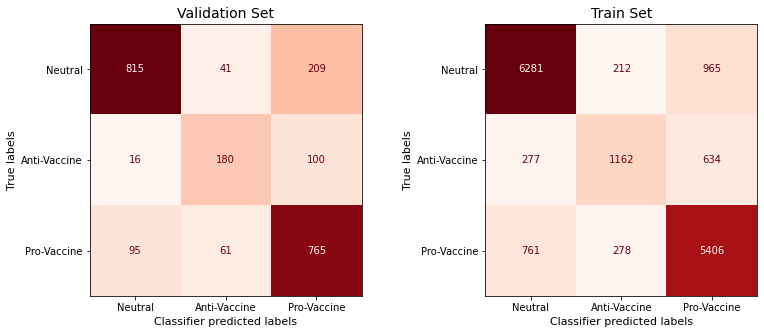

In [22]:
_, ax = plt.subplots(1, 2, figsize=(13,5))
plotConfusionMatrix(validItrlabels, validPredictions, 'Validation Set', CLASS_NAMES, ax[0])
plotConfusionMatrix(trainLabels, epochTrainPredictions, 'Train Set', CLASS_NAMES, ax[1])
plt.show()

In [23]:
scores = metricScores(epochTrainPredictions, validPredictions, trainLabels, validItrlabels)
metricStatsDF(scores, [PREC_KEY, REC_KEY, F1_KEY])

Train Set                 Validation Set                
             Precision  Recall      F1      Precision  Recall      F1
Neutral         0.8422  0.5605  0.8388         0.7653  0.6081  0.8306
Anti-Vaccine    0.8582  0.7034  0.7717         0.8801  0.6383  0.7123
Pro-Vaccine     0.8501  0.6239  0.8039         0.8187  0.6228  0.7669

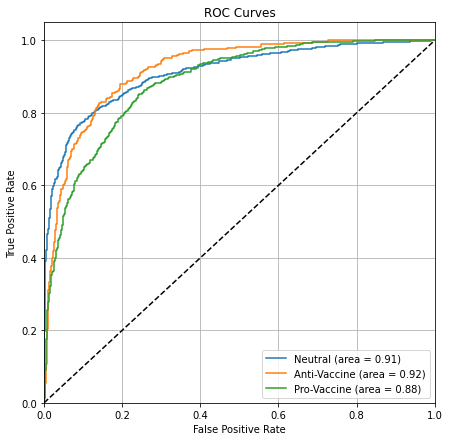

In [24]:
validOutputTensor = torch.empty(size=(len(validOutput), NUM_CLASSES))
for i, output in enumerate(validOutput):
    validOutputTensor[i] = output
rocScores = createRocCurves(torch.tensor(validItrlabels).int(), validOutputTensor)
plotRocCurves(*rocScores)